In [1]:
using QuantumCumulants
using OrdinaryDiffEq, ModelingToolkit
using DifferentialEquations
using PyPlot
using NPZ
import LinearAlgebra as la
# Define parameters
@cnumbers ω1 ω2 g γ1 γ2 Ω1 Ω2   # 1-magnon, 2-photon
h1 = FockSpace(:cavity);h2 = FockSpace(:cavity)
h=h1⊗h2
# Define the fundamental operators
@qnumbers b1::Destroy(h,1) b2::Destroy(h,2)

Ham = ω1*(b1'*b1) + ω2*(b2'*b2) +g*((b1'*b2)+(b2'*b1))+ Ω1*( b1'+b1) + Ω2*(b2'+b2)
# Collapse operators
J = [b1,b2]; rates = [2γ1,2γ2]
# Derive a set of equations
ops = [b1,b2]; eqs = meanfield(ops,Ham,J;rates=rates,order=1)


∂ₜ(⟨b1⟩) = (0 - 1im)*Ω1 + (0 - 1im)*g*⟨b2⟩ + (0 - 1im)*ω1*⟨b1⟩ - γ1*⟨b1⟩
∂ₜ(⟨b2⟩) = (0 - 1im)*Ω2 + (0 - 1im)*g*⟨b1⟩ + (0 - 1im)*ω2*⟨b2⟩ - γ2*⟨b2⟩


In [2]:
# Complete equations
eqs_completed = complete(eqs);
@named sys = ODESystem(eqs_completed);
A = calculate_jacobian(sys); B=[eqs_completed[1].rhs.dict[Ω1] * Ω1; eqs_completed[2].rhs.dict[Ω2] * Ω2];
Ainv=inv(A); X=Ainv*B; b1=X[1]; b2=X[2];

A

2×2 Matrix{Num}:
 (0-1im)*ω1 - γ1        (0-1im)*g
       (0-1im)*g  (0-1im)*ω2 - γ2

ComplexF64[3.950979310739394 + 0.0im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 + 0.0im]
ComplexF64[3.957540719709091 + 0.0im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 + 0.0im]
ComplexF64[3.964102128678788 + 0.0im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 + 0.0im]
ComplexF64[3.970663537648485 + 0.0im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 + 0.0im]
ComplexF64[3.977224946618182 + 0.0im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 + 0.0im]
ComplexF64[3.983786355587879 + 0.0im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 + 0.0im]
ComplexF64[3.990347764557576 + 0.0im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 + 0.0im]
ComplexF64[3.9969091735272726 + 0.0im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 + 0.0im]
ComplexF64[4.00347058249697 + 0.0im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 + 0.0im]
ComplexF64[4.010031991466667 + 0.0im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 + 0.0im]


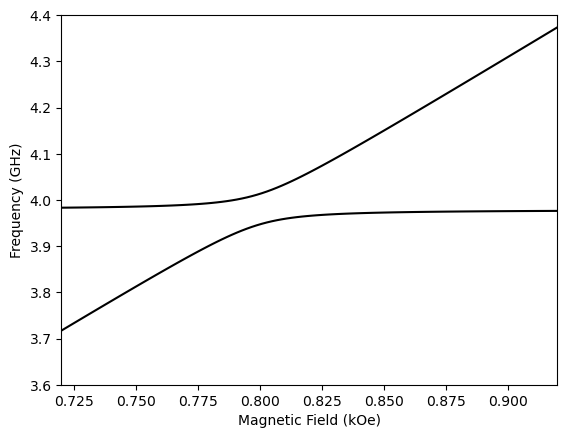

In [3]:
#Numerical calculations of dispersion spectra for case-1 (J > Γ)

γ1n=0.0; γ2n=0.0; 
gn=0.033;
ω2n = 3.9790176;
Hlist = range(0.720, 0.920, length=100) |> collect
occupationList1 = Float64[]; occupationList2 = Any[]
for H in Hlist
        An=substitute( A, Dict(ω1=>1.38284384+(3.24789744)*H,ω2=>ω2n,g=>gn,γ1=>γ1n,γ2=>γ2n))
        Ann = 1im * zeros(2,2)
        for i=1:2
            for j=1:2
                Ann[i,j] = real(An[i,j]).val + 1im * imag(An[i,j]).val
            end
        
        end
        if abs(H-0.8) < 1e-2
            println(Ann*1im)
        end
        data0=Ann * 1im
        data1 = la.eigen(data0)
    
        datar=la.real(data1.values)
        r1n=datar[1]; r2n=datar[2];
        #print(An)
    push!(occupationList1, r1n); push!(occupationList2, r2n)
end

using PyPlot
plot(Hlist,occupationList1,"k");plot(Hlist,occupationList2,"k")
xlabel("Magnetic Field (kOe)"); ylabel("Frequency (GHz)")

xlim(0.720, 0.920)
ylim(3.6, 4.4)
savefig("Example1.png")


In [4]:

using DelimitedFiles
file_path = raw"E:\Abhishek\Paper writting\paper_2_Ambt\Simulation data\QM.model.fitting.ring0 and ring 90 for 25um thickness\ring.720.920.5.csv"

data = readdlm(file_path, ',', Float64, '\n')
# Convert the DataFrame to a Julia matrix
s = Matrix(data)

i1 = 720
i2 = 920
t1 = 5
l1 = 3
l2 = 5
t2 = 0.0006666666

x = i1:t1:i2
y = l1:t2:l2  # Adjusted to ensure it covers the range [3, 5)

# Plot using 'jet' colormap and adjust colorbar scale
#heatmap(x, y, s, c=:jet, clim=(-7, 0),
#        xlabel="X-axis", ylabel="Y-axis", title="Contour Plot with Jet Colormap")

#pcolormesh(x/1000,y,s,cmap="jet",clim=(-7,0),levels=-7:0.1:0)
contourf(x/1000, y, s, cmap="jet", levels=-7:0.1:0)
plot(Hlist,occupationList1,"k");plot(Hlist,occupationList2,"k")

# Set custom y-axis range
#yaxis!((3.6, 4.4))
ylim(3.6,4.4)
# Save the figure with higher resolution (e.g., 300 dpi)
savefig("Example1.png")

@show pwd()
#display("image/png", read("Example.png"))
println("Size of x: ", size(x))
println("Size of y: ", size(y))
println("Size of s: ", size(s))



LoadError: ArgumentError: Cannot open 'E:\Abhishek\Paper writting\paper_2_Ambt\Simulation data\QM.model.fitting.ring0 and ring 90 for 25um thickness\ring.720.920.5.csv': not a file

ComplexF64[3.950979310739394 - 0.00014im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 - 0.003697im]
ComplexF64[3.957540719709091 - 0.00014im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 - 0.003697im]
ComplexF64[3.964102128678788 - 0.00014im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 - 0.003697im]
ComplexF64[3.970663537648485 - 0.00014im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 - 0.003697im]
ComplexF64[3.977224946618182 - 0.00014im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 - 0.003697im]
ComplexF64[3.983786355587879 - 0.00014im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 - 0.003697im]
ComplexF64[3.990347764557576 - 0.00014im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 - 0.003697im]
ComplexF64[3.9969091735272726 - 0.00014im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 - 0.003697im]
ComplexF64[4.00347058249697 - 0.00014im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 - 0.003697im]
ComplexF64[4.010031991466667 - 0.00014im 0.033 + 0.0im; 0.033 + 0.0im 3.9790176 - 0.003697im]


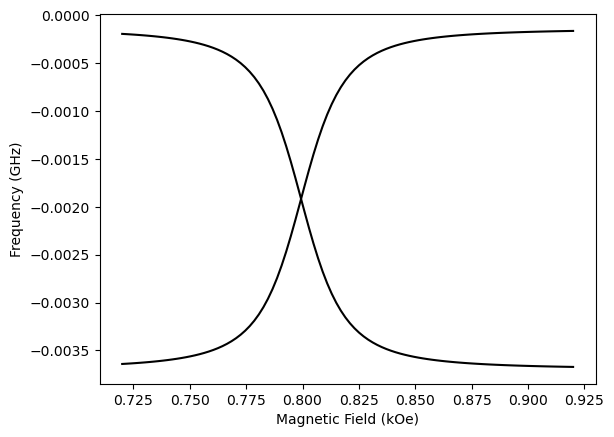

In [5]:
#Numerical calculations of resonance linewidths (J > Γ)

γ1n=0.00014; γ2n=0.003697; 
gn=0.033;
ω2n = 3.9790176;
Hlist = range(0.720, 0.920, length=100) |> collect
occupationList1 = Float64[]; occupationList2 = Any[]
for H in Hlist
        An=substitute( A, Dict(ω1=>1.38284384+(3.24789744)*H,ω2=>ω2n,g=>gn,γ1=>γ1n,γ2=>γ2n))
        Ann = 1im * zeros(2,2)
        for i=1:2
            for j=1:2
                Ann[i,j] = real(An[i,j]).val + 1im * imag(An[i,j]).val
            end
        
        end
        if abs(H-0.8) < 1e-2
            println(Ann*1im)
        end
        data0=Ann*1im
        data1 = la.eigen(data0)
    
        datar=la.imag(data1.values)
        r1n=datar[1]; r2n=datar[2];
        #println(datar)
    
    push!(occupationList1, r1n); push!(occupationList2, r2n)
end

using PyPlot
plot(Hlist,occupationList1,"k");plot(Hlist,occupationList2,"k")
xlabel("Magnetic Field (kOe)"); ylabel("Frequency (GHz)")

#xlim(0.720, 0.920)
#ylim(3.6, 4.4)
savefig("Example1.png")


ComplexF64[3.950979310739394 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[3.957540719709091 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[3.964102128678788 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[3.970663537648485 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[3.977224946618182 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[3.983786355587879 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[3.990347764557576 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[3.9969091735272726 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[4.00347058249697 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[4.010031991466667 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]


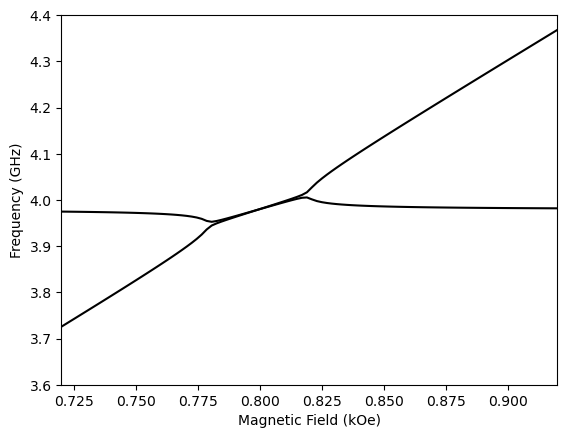

In [6]:
#Numerical calculations of dispersion spectra for case-1 (J < Γ)

γ1n=0.00014; γ2n=0.003697; 
gn=0.033*1im;
ω2n = 3.9790176;
Hlist = range(0.720, 0.920, length=100) |> collect
occupationList1 = Float64[]; occupationList2 = Any[]
for H in Hlist
        An=substitute( A, Dict(ω1=>1.38284384+(3.24789744)*H,ω2=>ω2n,g=>gn,γ1=>γ1n,γ2=>γ2n))
        Ann = 1im * zeros(2,2)
        for i=1:2
            for j=1:2
                Ann[i,j] = real(An[i,j]).val + 1im * imag(An[i,j]).val
            end
        
        end
        if abs(H-0.8) < 1e-2
            println(Ann*1im)
        end
        data0=Ann * 1im
        data1 = la.eigen(data0)
    
        datar=la.real(data1.values)
        r1n=datar[1]; r2n=datar[2];
    
    push!(occupationList1, r1n); push!(occupationList2, r2n)
end

using PyPlot
plot(Hlist,occupationList1,"k");plot(Hlist,occupationList2,"k")
xlabel("Magnetic Field (kOe)"); ylabel("Frequency (GHz)")

xlim(0.720, 0.920)
ylim(3.6, 4.4)
savefig("Example1.png")


ComplexF64[3.950979310739394 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[3.957540719709091 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[3.964102128678788 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[3.970663537648485 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[3.977224946618182 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[3.983786355587879 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[3.990347764557576 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[3.9969091735272726 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[4.00347058249697 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]
ComplexF64[4.010031991466667 - 0.00014im 0.0 + 0.033im; 0.0 + 0.033im 3.9790176 - 0.003697im]


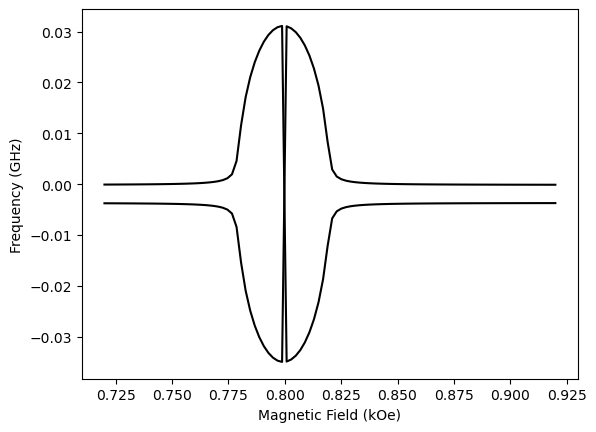

In [7]:
#Numerical calculations of resonance linewidths (J > Γ)

γ1n=0.00014; γ2n=0.003697; 
gn=0.033*1im;
ω2n = 3.9790176;
Hlist = range(0.720, 0.920, length=100) |> collect
occupationList1 = Float64[]; occupationList2 = Any[]
for H in Hlist
        An=substitute( A, Dict(ω1=>1.38284384+(3.24789744)*H,ω2=>ω2n,g=>gn,γ1=>γ1n,γ2=>γ2n))
        Ann = 1im * zeros(2,2)
        for i=1:2
            for j=1:2
                Ann[i,j] = real(An[i,j]).val + 1im * imag(An[i,j]).val
            end
        
        end
        if abs(H-0.8) < 1e-2
            println(Ann*1im)
        end
        data0=Ann*1im
        data1 = la.eigen(data0)
    
        datar=la.imag(data1.values)
        r1n=datar[1]; r2n=datar[2];
        #println(datar)
    
    push!(occupationList1, r1n); push!(occupationList2, r2n)
end

using PyPlot
plot(Hlist,occupationList1,"k");plot(Hlist,occupationList2,"k")
xlabel("Magnetic Field (kOe)"); ylabel("Frequency (GHz)")

#xlim(0.720, 0.920)
#ylim(3.6, 4.4)
savefig("Example1.png")
